In [2]:
# ---------------------------------------------------------------------
# Full Hybrid Phishing URL Detection — Colab-ready
# ---------------------------------------------------------------------
# Copy this whole cell into Google Colab and run.
# If your CSV is in Google Drive, update `file_path` accordingly.
# ---------------------------------------------------------------------

# 0) Install required packages (first run only)
!pip install -q lightgbm xgboost sentence-transformers scikit-learn matplotlib tqdm pandas numpy



^C


In [10]:
# 1) Mount Google Drive (will prompt for auth)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 2) Imports
import os
import re
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix
from sklearn.linear_model import LogisticRegression

from sentence_transformers import SentenceTransformer
import lightgbm as lgb
import xgboost as xgb

In [1]:
# 3) Load CSV from Google Drive — CHANGE PATH if needed
file_path = "/content/drive/MyDrive/archive (4).csv"   # <- change if your file is elsewhere
if not os.path.exists(file_path):
    raise FileNotFoundError(f"File not found: {file_path}. Update file_path to your CSV location in Drive.")

df = pd.read_csv(file_path)
print("✅ Loaded CSV. Raw shape:", df.shape)
print(df.head(5))

NameError: name 'os' is not defined

In [13]:
# 4) Normalize column names and map labels
df.columns = [c.strip().lower() for c in df.columns]

# Ensure we have 'url' and 'label' columns
if 'url' not in df.columns and 'u rl' in df.columns:
    df.rename(columns={'u rl':'url'}, inplace=True)
# try common alternatives
if 'url' not in df.columns:
    for c in df.columns:
        if 'url' in c:
            df.rename(columns={c:'url'}, inplace=True)
            break

if 'label' not in df.columns:
    for c in df.columns:
        if 'lab' in c:
            df.rename(columns={c:'label'}, inplace=True)
            break

# Now require url and label
if 'url' not in df.columns or 'label' not in df.columns:
    raise KeyError("CSV must contain URL and Label columns. Found columns: " + ", ".join(df.columns))

# Map label values (common: 'good'/'bad' or 'benign'/'phishing' etc.)
label_vals = df['label'].astype(str).str.lower().unique().tolist()
print("Label values found:", label_vals)

# Try mapping multiple variants to 0/1
label_map = {}
for v in label_vals:
    if any(x in v for x in ['good','benign','legit','legitimate','normal','clean']):
        label_map[v] = 0
    elif any(x in v for x in ['bad','phish','phishing','malicious','malware','suspicious']):
        label_map[v] = 1
    else:
        # fallback: keep unknown—will error later if unmapped
        label_map[v] = None

# If mapping produced None for any label, try mapping common exact values
for v in label_vals:
    if label_map[v] is None:
        if v in ['0','1']:
            label_map[v] = int(v)
        elif v == 'phishing':
            label_map[v] = 1
        elif v == 'good':
            label_map[v] = 0
        else:
            # fallback: ask to treat any non-'good' as phishing
            label_map[v] = 1

print("Using label map (sample):", {k:label_map[k] for k in list(label_map)[:6]})
df['label'] = df['label'].astype(str).str.lower().map(label_map)

# Drop rows not mapped (if any)
df = df.dropna(subset=['url','label']).reset_index(drop=True)
df['label'] = df['label'].astype(int)
print("✅ Cleaned dataset shape (after label mapping):", df.shape)
print(df['label'].value_counts())

Label values found: ['bad', 'good']
Using label map (sample): {'bad': 1, 'good': 0}
✅ Cleaned dataset shape (after label mapping): (549346, 2)
label
0    392924
1    156422
Name: count, dtype: int64


In [14]:
# 5) Basic URL cleaning
def clean_url(u):
    u = str(u).strip()
    u = re.sub(r"https?://", "", u)
    u = re.sub(r"^www\.", "", u)
    return u.lower()

df['url'] = df['url'].apply(clean_url)

# Print a few samples
print("\nSample URLs:")
print(df['url'].sample(5).tolist())


Sample URLs:
['houseofnames.com/nesbitt-family-crest', 'dailyexaminer.com.au/story/2011/08/27/warning-follows-fire-deaths/', 'stlouisrams.com/news-and-events/article-1/rams-honor-st-louis-cardinals-2011-season-with-2300-tickets/482aceb4-8e09-49c4-ae18-9622c8f03afc', 'upi.com/topic/dan_aykroyd/', 'bot.wowstead.com/forums/band-of-thorns-public-forum/general-wow-discussion/1311888-eternal-embers']


In [15]:
# 6) Lexical features extraction
def extract_lexical_features(url):
    features = {}
    features['url_length'] = len(url)
    features['num_dots'] = url.count('.')
    features['num_hyphens'] = url.count('-')
    features['num_underscores'] = url.count('_')
    features['num_digits'] = sum(c.isdigit() for c in url)
    features['has_ip'] = 1 if re.search(r'\d+\.\d+\.\d+\.\d+', url) else 0
    features['has_at'] = 1 if '@' in url else 0
    features['num_params'] = url.count('=')
    features['num_slashes'] = url.count('/')
    features['num_subdirs'] = max(0, len(url.split('/')) - 1)
    # simple char entropy
    try:
        entropy = -sum((url.count(c)/len(url)) * math.log2(url.count(c)/len(url)) for c in set(url))
    except:
        entropy = 0.0
    features['entropy'] = round(entropy, 3)
    return features

print("\nExtracting lexical features (this may take a few seconds)...")
lexical_df = pd.DataFrame([extract_lexical_features(u) for u in tqdm(df['url'].tolist())])
lexical_df = lexical_df.fillna(0)
print("Lexical features shape:", lexical_df.shape)


Extracting lexical features (this may take a few seconds)...


  0%|          | 0/549346 [00:00<?, ?it/s]

Lexical features shape: (549346, 11)


In [ ]:
# 7) TF-IDF (chachar', ngram_range=(3,5), max_features=5000)
X_tfidf = tfidf.fit_transform(df['url'])
svd = TruncatedSVD(n_components=50, random_state=42)
X_svd = svd.fit_transform(X_tfidf)
print("SVD features shape:", X_svd.shape)r n-grams) + TruncatedSVD
print("\nComputing TF-IDF (char 3-5) and SVD (this can take ~1-3 min depending on dataset size)...")
tfidf = TfidfVectorizer(analyzer='


Computing TF-IDF (char 3-5) and SVD (this can take ~1-3 min depending on dataset size)...
SVD features shape: (549346, 50)


In [17]:
# 8) SentenceTransformer embeddings (semantic)
print("\nGenerating sentence-transformer embeddings (all-MiniLM-L6-v2). This will download a model the first time.")
model_emb = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model_emb.encode(df['url'].tolist(), show_progress_bar=True, batch_size=64)
embeddings = np.array(embeddings)
print("Embeddings shape:", embeddings.shape)


Generating sentence-transformer embeddings (all-MiniLM-L6-v2). This will download a model the first time.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/8584 [00:00<?, ?it/s]

Embeddings shape: (549346, 384)


In [18]:
 # 9) Combine features
X = np.hstack([lexical_df.values, embeddings, X_svd])
y = df['label'].values
print("\nCombined feature matrix shape:", X.shape)
print("Labels shape:", y.shape)


Combined feature matrix shape: (549346, 445)
Labels shape: (549346,)


In [19]:
# 10) Train/Val/Test split (stratified, reproducible)
RND = 42
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=RND, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=RND, stratify=y_temp)

print("\nDataset split sizes:")
print("Train:", X_train.shape[0])
print("Validation:", X_val.shape[0])
print("Test:", X_test.shape[0])


Dataset split sizes:
Train: 384542
Validation: 82402
Test: 82402


In [20]:
# 11) Train LightGBM
print("\nTraining LightGBM...")
lgb_model = lgb.LGBMClassifier(
    n_estimators=300, max_depth=10, learning_rate=0.05,
    num_leaves=64, subsample=0.9, colsample_bytree=0.9, random_state=RND
)
lgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='logloss')
lgb_proba = lgb_model.predict_proba(X_test)[:,1]
lgb_pred = (lgb_proba > 0.5).astype(int)
lgb_acc = accuracy_score(y_test, lgb_pred)
lgb_fpr, lgb_tpr, _ = roc_curve(y_test, lgb_proba)
lgb_auc = auc(lgb_fpr, lgb_tpr)
print(f"LightGBM -> Accuracy: {lgb_acc*100:.4f}% | AUC: {lgb_auc:.4f}")


Training LightGBM...
[LightGBM] [Info] Number of positive: 109495, number of negative: 275047
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.543257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 111533
[LightGBM] [Info] Number of data points in the train set: 384542, number of used features: 445
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.284741 -> initscore=-0.921063
[LightGBM] [Info] Start training from score -0.921063
LightGBM -> Accuracy: 95.8520% | AUC: 0.9906


In [21]:

# 12) Train XGBoost
print("\nTraining XGBoost...")
xgb_model = xgb.XGBClassifier(
    n_estimators=300, max_depth=10, learning_rate=0.05,
    subsample=0.9, colsample_bytree=0.9, use_label_encoder=False, eval_metric='logloss', random_state=RND
)
xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
xgb_proba = xgb_model.predict_proba(X_test)[:,1]
xgb_pred = (xgb_proba > 0.5).astype(int)
xgb_acc = accuracy_score(y_test, xgb_pred)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_proba)
xgb_auc = auc(xgb_fpr, xgb_tpr)
print(f"XGBoost  -> Accuracy: {xgb_acc*100:.4f}% | AUC: {xgb_auc:.4f}")


Training XGBoost...
XGBoost  -> Accuracy: 96.9260% | AUC: 0.9943


In [22]:
# 13) Stacking meta-learner (Logistic Regression)
print("\nTraining stacked hybrid model (LogisticRegression meta-learner)...")
lgb_val_proba = lgb_model.predict_proba(X_val)[:,1]
xgb_val_proba = xgb_model.predict_proba(X_val)[:,1]
stack_features_val = np.vstack([lgb_val_proba, xgb_val_proba]).T

meta_model = LogisticRegression(max_iter=1000, random_state=RND)
meta_model.fit(stack_features_val, y_val)

stack_test = np.vstack([lgb_proba, xgb_proba]).T
hyb_proba = meta_model.predict_proba(stack_test)[:,1]
hyb_pred = (hyb_proba > 0.5).astype(int)
hyb_acc = accuracy_score(y_test, hyb_pred)
hyb_fpr, hyb_tpr, _ = roc_curve(y_test, hyb_proba)
hyb_auc = auc(hyb_fpr, hyb_tpr)
print(f"Hybrid    -> Accuracy: {hyb_acc*100:.4f}% | AUC: {hyb_auc:.4f}")


Training stacked hybrid model (LogisticRegression meta-learner)...
Hybrid    -> Accuracy: 97.0680% | AUC: 0.9943


In [23]:
# 14) Print summary metrics
print("\n=== Summary Metrics ===")
print(f"LightGBM -> Accuracy: {lgb_acc*100:.4f}% | AUC: {lgb_auc:.4f}")
print(f"XGBoost  -> Accuracy: {xgb_acc*100:.4f}% | AUC: {xgb_auc:.4f}")
print(f"Hybrid   -> Accuracy: {hyb_acc*100:.4f}% | AUC: {hyb_auc:.4f}")


=== Summary Metrics ===
LightGBM -> Accuracy: 95.8520% | AUC: 0.9906
XGBoost  -> Accuracy: 96.9260% | AUC: 0.9943
Hybrid   -> Accuracy: 97.0680% | AUC: 0.9943


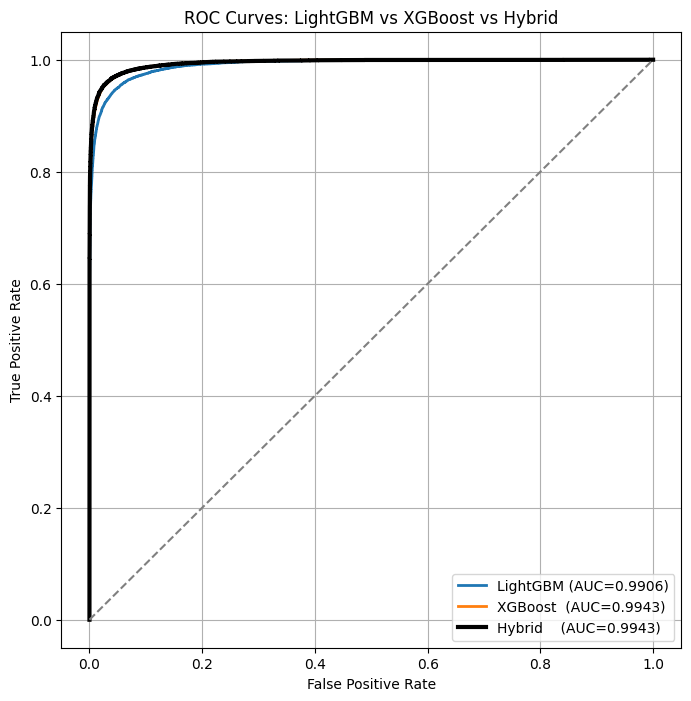

In [24]:
# 15) ROC plot (all models)
plt.figure(figsize=(8,8))
plt.plot(lgb_fpr, lgb_tpr, label=f"LightGBM (AUC={lgb_auc:.4f})", linewidth=2)
plt.plot(xgb_fpr, xgb_tpr, label=f"XGBoost  (AUC={xgb_auc:.4f})", linewidth=2)
plt.plot(hyb_fpr, hyb_tpr, label=f"Hybrid    (AUC={hyb_auc:.4f})", linewidth=3, color='black')
plt.plot([0,1],[0,1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves: LightGBM vs XGBoost vs Hybrid")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

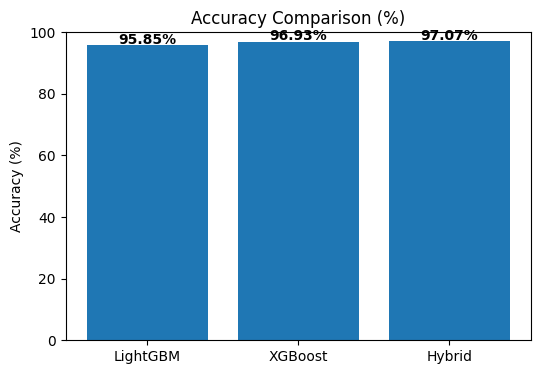

In [25]:
# 16) Accuracy comparison bar chart
plt.figure(figsize=(6,4))
models = ['LightGBM','XGBoost','Hybrid']
accs = [lgb_acc*100, xgb_acc*100, hyb_acc*100]
bars = plt.bar(models, accs)
plt.ylim(0,100)
plt.title("Accuracy Comparison (%)")
plt.ylabel("Accuracy (%)")
for i,b in enumerate(bars):
    plt.text(b.get_x() + b.get_width()/2, accs[i]+0.5, f"{accs[i]:.2f}%", ha='center', fontweight='bold')
plt.show()

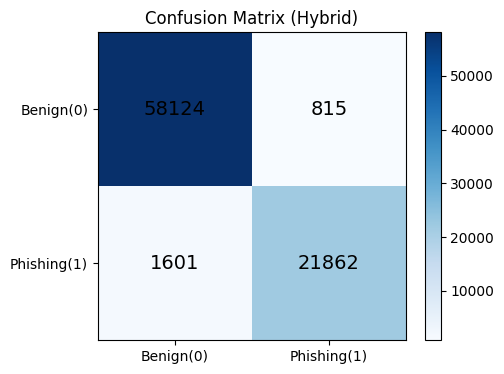

In [26]:
# 17) Confusion matrix for Hybrid model
cm = confusion_matrix(y_test, hyb_pred)
plt.figure(figsize=(5,4))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix (Hybrid)")
plt.xticks([0,1], ['Benign(0)','Phishing(1)'])
plt.yticks([0,1], ['Benign(0)','Phishing(1)'])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i,j], ha='center', va='center', color='black', fontsize=14)
plt.colorbar()
plt.show()

In [27]:
# 18) Classification report for Hybrid
print("\nClassification Report (Hybrid):")
print(classification_report(y_test, hyb_pred, digits=4))


Classification Report (Hybrid):
              precision    recall  f1-score   support

           0     0.9732    0.9862    0.9796     58939
           1     0.9641    0.9318    0.9476     23463

    accuracy                         0.9707     82402
   macro avg     0.9686    0.9590    0.9636     82402
weighted avg     0.9706    0.9707    0.9705     82402



In [28]:
# 19) Save models to Drive (optional)
save_dir = "/content/drive/MyDrive/phish_models"
os.makedirs(save_dir, exist_ok=True)
import joblib
joblib.dump(lgb_model, os.path.join(save_dir, "lgb_model.joblib"))
joblib.dump(xgb_model, os.path.join(save_dir, "xgb_model.joblib"))
joblib.dump(meta_model, os.path.join(save_dir, "hybrid_meta.joblib"))
print(f"\nModels saved to {save_dir}")


Models saved to /content/drive/MyDrive/phish_models
